In [1]:
import os
import time
import numpy 
import numpy as np
from scipy import signal

from argparse import ArgumentParser

import matplotlib.pyplot as pyplot
import matplotlib.pyplot as plt

from scipy import interpolate
from astropy.cosmology import Planck15 as cosmo 

from itertools import product
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import ma
from scipy.interpolate import RegularGridInterpolator, RectBivariateSpline

from astropy.cosmology import Planck15


In [2]:
from astropy.convolution import interpolate_replace_nans
from astropy.convolution import Gaussian2DKernel

In [3]:
np.set_printoptions(suppress=True)

In [4]:
pad_zmet = np.array([0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0008, 0.001, 0.0012, 0.0016, 0.0020, 0.0025, 0.0031, 0.0039, 0.0049, 0.0061, 0.0077, 0.0096, 0.012, 0.015, 0.019, 0.024, 0.03])
pad_zmetsol = 0.019

pad_solmet = pad_zmet/pad_zmetsol
zmets = np.append((np.linspace(0, 10, 11)*2 + 1).astype(int), [22.])
zsolmets = pad_solmet[(zmets-1).astype(int)] 

#ages = Planck15.age(10**np.linspace(-0.824, -2.268, 25))[-7:-5].value
time_steps = Planck15.age(10**np.linspace(-0.824, -3.295, 15)).reshape(-1,1,1).value
taus = 10**np.linspace(6, 9.778, 50)/1e9

with np.load('../data/emls_par_pool_mapped_nozshift_ppxfcorrect_AA_12zmet.npz') as orig_pred:
    pred = orig_pred['lookup']
    
with np.load('../data/emls_mask_par_pool_mapped_nozshift_ppxfcorrect_AA_12zmet.npz') as orig_mask:
    mask = orig_mask['lookupmask']
    
tqs = np.append(np.flip(time_steps.flatten()[0]- 10**(np.linspace(7, np.log10((time_steps.flatten()[0]-0.1)*1e9), 48))/1e9, axis=0), [time_steps.flatten()[0]-0.001, time_steps.flatten()[0]+0.1], axis=0)

sv = np.array(list(product(time_steps[0][0], tqs, np.log10(taus), zsolmets)))
for n in range(1, len(time_steps)):
    tqs = np.append(np.flip(time_steps.flatten()[n]- 10**(np.linspace(7, np.log10((time_steps.flatten()[n]-0.1)*1e9), 48))/1e9, axis=0), [time_steps.flatten()[n]-0.001, time_steps.flatten()[n]+0.1], axis=0)
    sv = np.append(sv, np.array(list(product(time_steps[n][0], tqs, np.log10(taus), zsolmets))), axis=0)
    


In [5]:
with np.load('../data/emls_par_pool_mapped_nozshift_ppxfcorrect_AA_22zmet.npz') as orig_pred:
    pred22 = orig_pred['lookup']
    
with np.load('../data/emls_mask_par_pool_mapped_nozshift_ppxfcorrect_AA_22zmet.npz') as orig_mask:
    mask22 = orig_mask['lookupmask']

In [7]:
lum = np.ma.masked_array(data=pred, mask=mask).reshape(15, 50, 50, 11, -1)

ValueError: cannot reshape array of size 4050000 into shape (15,50,50,11,newaxis)

In [82]:
lum22 = np.ma.masked_array(data=pred22, mask=mask22).reshape(15, 50, 50, 1, -1)

In [87]:
preds = np.append(lum.data, lum22.data, axis=3)
masks = np.append(lum.mask, lum22.mask, axis=3)

In [95]:
lums = np.ma.masked_array(data=preds, mask=masks).reshape(-1, 9)

In [98]:
lums.mask.shape

(450000, 9)

In [100]:
np.savez('../data/emls_par_pool_mapped_nozshift_ppxfcorrect_AA_12zmet.npz', lookup=lums.data)
np.savez('../data/emls_masl_par_pool_mapped_nozshift_ppxfcorrect_AA_12zmet.npz', lookupmask=lums.mask)

In [5]:
lum = np.ma.masked_array(data=pred, mask=mask).reshape(15, 50, 50, 12, -1)

In [6]:
mgfe = np.sqrt( lum[:,:,:,:,2] * ( 0.72*lum[:,:,:,:,3] + 0.28*lum[:,:,:,:,4] )  )  

In [7]:
emlinesdata = np.load('emlines_data.npy')
indx_names = np.load('index_names.npy')

In [8]:
from IPython.html.widgets import interact

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [9]:
def browse_images(lum):
    f = lum.shape[0]
    g = lum.shape[3]
    def view_image(f, g):
        tqs = np.append(np.flip(time_steps.flatten()[f]- 10**(np.linspace(7, np.log10((time_steps.flatten()[f]-0.1)*1e9), 48))/1e9, axis=0), [time_steps.flatten()[f]-0.001, time_steps.flatten()[f]+0.1], axis=0)
        fig =plt.figure(figsize=(17,8))
        ax = plt.subplot2grid((2,3), (0, 0))
        cb = ax.pcolor(time_steps[f]-tqs[1:], taus, lum[f, 1:,:, g, 0].T,  cmap=plt.cm.gnuplot2, vmax=68)
       # ax.set_xlim(np.max(time_steps[f]-tqs[15:]), np.min(time_steps[f]-tqs[15:]))
        ax.set_xlim(5, 0)
        ax.set_ylim(np.min(taus), np.max(taus))

        the_divider = make_axes_locatable(ax)
        cax = the_divider.append_axes("right", size="5%", pad=0.2)

        cbar = plt.colorbar(cb, cax=cax)
        cbar.set_label(r'EW[H $\alpha$]', labelpad=2)
        ax.set_xlabel(r'$t_q$ $\rm{[Gyr]}$')
        ax.set_ylabel(r'$\tau$ $\rm{[Gyr]}$')
        ax.minorticks_on()
                
        
        ax = plt.subplot2grid((2,3), (0, 1))
        cb = ax.pcolor(time_steps[f]-tqs[1:], taus, lum[f, 1:,:, g,1].T, cmap=plt.cm.gnuplot2)
        #ax.set_xlim(np.min(time_steps[f]-tqs[15:]), np.max(time_steps[f]-tqs[15:]))
        ax.set_ylim(np.min(taus), np.max(taus))
        ax.set_xlim(5, 0)
        
        the_divider = make_axes_locatable(ax)
        cax = the_divider.append_axes("right", size="5%", pad=0.2)

        cbar = plt.colorbar(cb, cax=cax)
        cbar.set_label(r'H $\beta$', labelpad=2)
        ax.set_ylabel(r'$\tau$ $\rm{[Gyr]}$')
        ax.minorticks_on()
                       
        ax = plt.subplot2grid((2,3), (0,2))
        mgfe = np.sqrt( lum[f, 1:,:, g,2].T * ( 0.72*lum[f, 1:,:, g,3].T + 0.28*lum[f, 1:,:, g,4].T )  )
        cb = ax.pcolor(time_steps[f]-tqs[1:], taus, mgfe,  cmap=plt.cm.gnuplot2)
        #ax.set_xlim(np.min(time_steps[f]-tqs[15:]), np.max(time_steps[f]-tqs[15:]))
        ax.set_xlim(5, 0)
        ax.set_ylim(np.min(taus), np.max(taus))

        the_divider = make_axes_locatable(ax)
        cax = the_divider.append_axes("right", size="5%", pad=0.2)

        cbar = plt.colorbar(cb, cax=cax)
        cbar.set_label(r'$MgFe$', labelpad=2)
        ax.set_ylabel(r'$\tau$ $\rm{[Gyr]}$')
        ax.minorticks_on()
        
        ax = plt.subplot2grid((2,3), (1, 0))
        cb = ax.pcolor(time_steps[f]-tqs[1:],taus, lum[f, 1:,:, g,5].T, cmap=plt.cm.gnuplot2)
        #ax.set_xlim(np.min(tqs[15:]), np.max(tqs[15:]))
        ax.set_xlim(5, 0)
        ax.set_ylim(np.min(taus), np.max(taus))

        the_divider = make_axes_locatable(ax)
        cax = the_divider.append_axes("right", size="5%", pad=0.2)

        cbar = plt.colorbar(cb, cax=cax)
        cbar.set_label(r'H $\delta_A$', labelpad=2)
        ax.set_ylabel(r'$\tau$ $\rm{[Gyr]}$')
        ax.minorticks_on()
        
        ax = plt.subplot2grid((2,3), (1, 1))
        cb = ax.pcolor(time_steps[f]-tqs[1:], taus, lum[f, 1:,:, g,6].T, cmap=plt.cm.gnuplot2_r)
        #ax.set_xlim(np.min(time_steps[f]-tqs[15:]), np.max(time_steps[f]-tqs[15:]))
        ax.set_xlim(5, 0)
        ax.set_ylim(np.min(taus), np.max(taus))

        the_divider = make_axes_locatable(ax)
        cax = the_divider.append_axes("right", size="5%", pad=0.2)

        cbar = plt.colorbar(cb, cax=cax)
        cbar.set_label(r'D4000', labelpad=2)
        ax.set_ylabel(r'$\tau$ $\rm{[Gyr]}$')
        ax.minorticks_on()
        
        ax = plt.subplot2grid((2,3), (1, 2))
        cb = ax.pcolor(time_steps[f]-tqs[1:], taus, lum[f, 1:,:, g,7].T, cmap=plt.cm.gnuplot2_r)
        #ax.set_xlim(np.min(time_steps[f]-tqs[15:]), np.max(time_steps[f]-tqs[15:]))
        ax.set_xlim(5, 0)
        ax.set_ylim(np.min(taus), np.max(taus))

        the_divider = make_axes_locatable(ax)
        cax = the_divider.append_axes("right", size="5%", pad=0.2)

        cbar = plt.colorbar(cb, cax=cax)
        cbar.set_label(r'Dn4000', labelpad=2)
        ax.set_ylabel(r'$\tau$ $\rm{[Gyr]}$')
        ax.minorticks_on()
        
        plt.title(r'$t_{\rm{obs}}$: %.5g $\rm{Gyr}$' % time_steps[f] +  r', $Z$: %.5g' % zsolmets[g])
        plt.tight_layout()
        #plt.subplots_adjust(hspace=0.1)
        plt.show()
        
    interact(view_image, f=(0,f-1), g=(0,g-1))


In [10]:
browse_images(lum)

interactive(children=(IntSlider(value=7, description='f', max=14), IntSlider(value=5, description='g', max=11)…

In [9]:
os.environ['PATH'] = os.environ['PATH'] + ':/usr/texbin'

plt.rc('figure', facecolor='none', edgecolor='none', autolayout=True)
plt.rc('path', simplify=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize='large', facecolor='none', linewidth=0.7, color_cycle = ['k', 'r', 'g', 'b', 'c', 'm', 'y'])
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('lines', markersize=4, linewidth=1, markeredgewidth=0.2)
plt.rc('legend', numpoints=1, frameon=False, handletextpad=0.3, scatterpoints=1, handlelength=2, handleheight=0.1)
plt.rc('savefig', facecolor='none', edgecolor='none', frameon='False')

params =   {'font.size' : 20,
            'xtick.major.size': 8,
            'ytick.major.size': 8,
            'xtick.minor.size': 3,
            'ytick.minor.size': 3,
            }
plt.rcParams.update(params) 

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


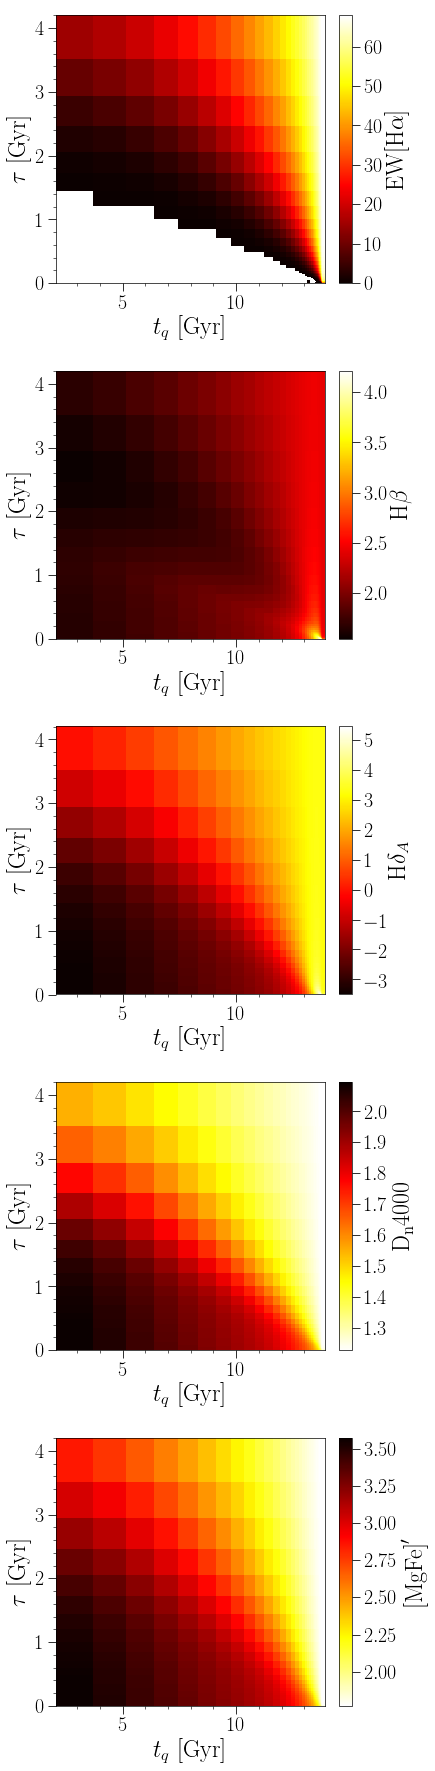

In [11]:
f = -1
g = 9

tqs = np.append(np.flip(time_steps.flatten()[f]- 10**(np.linspace(7, np.log10((time_steps.flatten()[f]-0.1)*1e9), 48))/1e9, axis=0), [time_steps.flatten()[f]-0.001, time_steps.flatten()[f]+0.1], axis=0)

fig =plt.figure(figsize=(6.45,25))
ax = plt.subplot2grid((5,1), (0, 0))
cb = ax.pcolor(tqs[1:], taus[:-2], lum[f,1:,:-2, g, 0].T,  cmap=plt.cm.hot, vmin=0, vmax=68)
# ax.set_xlim(np.max(time_steps[f]-tqs[1:]), np.min(time_steps[f]-tqs[1:]))
ax.set_xlim(np.min(tqs[1:]), np.max(tqs[1:]))
ax.set_ylim(np.min(taus[:-2]),np.max(taus[:-2]))

the_divider = make_axes_locatable(ax)
cax = the_divider.append_axes("right", size="5%", pad=0.2)

cbar = plt.colorbar(cb, cax=cax)
cbar.set_label(r'EW[H$\alpha$]', labelpad=3)
ax.set_xlabel(r'$t_q$ $\rm{[Gyr]}$')
ax.set_ylabel(r'$\tau$ $\rm{[Gyr]}$')
ax.minorticks_on()

# ax = plt.subplot2grid((2,3), (0, 1))
# cb = ax.pcolor(tqs[1:], taus, lum[f,1:,:, g,1].T, cmap=plt.cm.hot)
# ax.set_xlim(np.min(tqs[1:]), np.max(tqs[1:]))
# ax.set_ylim(np.min(taus), np.max(taus))

# the_divider = make_axes_locatable(ax)
# cax = the_divider.append_axes("right", size="5%", pad=0.2)

# cbar = plt.colorbar(cb, cax=cax)
# cbar.set_label(r'EW [OII]', labelpad=2)
# ax.set_ylabel(r'$\tau$ $\rm{[Gyr]}$')
# ax.minorticks_on()

ax = plt.subplot2grid((5,1), (1, 0))
cb = ax.pcolor(tqs[1:], taus[:-2], lum[f,1:,:-2, g,1].T, cmap=plt.cm.hot)
ax.set_xlim(np.min(tqs[1:]), np.max(tqs[1:]))
ax.set_ylim(np.min(taus[:-2]), np.max(taus[:-2]))

the_divider = make_axes_locatable(ax)
cax = the_divider.append_axes("right", size="5%", pad=0.2)

cbar = plt.colorbar(cb, cax=cax)
cbar.set_label(r'H$\beta$', labelpad=3)
ax.set_xlabel(r'$t_q$ $\rm{[Gyr]}$')
ax.set_ylabel(r'$\tau$ $\rm{[Gyr]}$')

ax.minorticks_on()

ax = plt.subplot2grid((5,1), (4,0))
mgfe = np.sqrt( lum[f,1:,:-2, g,2].T * ( 0.72*lum[f,1:,:-2, g,3].T + 0.28*lum[f,1:,:-2, g,4].T )  )
cb = ax.pcolor(tqs[1:], taus[:-2], mgfe,  cmap=plt.cm.hot_r)
ax.set_xlim(np.min(tqs[1:]), np.max(tqs[1:]))
ax.set_ylim(np.min(taus[:-2]), np.max(taus[:-2]))

the_divider = make_axes_locatable(ax)
cax = the_divider.append_axes("right", size="5%", pad=0.2)

cbar = plt.colorbar(cb, cax=cax)
cbar.set_label(r'$\rm{[MgFe]}^{\prime}$', labelpad=5)
ax.set_xlabel(r'$t_q$ $\rm{[Gyr]}$')
ax.set_ylabel(r'$\tau$ $\rm{[Gyr]}$')

ax.minorticks_on()

ax = plt.subplot2grid((5,1), (2,0))
cb = ax.pcolor(tqs[1:], taus[:-2], lum[f,1:,:-2, g,5].T, cmap=plt.cm.hot)
ax.set_xlim(np.min(tqs[1:]), np.max(tqs[1:]))
ax.set_ylim(np.min(taus[:-2]), np.max(taus[:-2]))

the_divider = make_axes_locatable(ax)
cax = the_divider.append_axes("right", size="5%", pad=0.2)

cbar = plt.colorbar(cb, cax=cax)
cbar.set_label(r'H$\delta_A$', labelpad=3)
ax.set_xlabel(r'$t_q$ $\rm{[Gyr]}$')
ax.set_ylabel(r'$\tau$ $\rm{[Gyr]}$')

ax.minorticks_on()

ax = plt.subplot2grid((5,1), (3,0))
cb = ax.pcolor(tqs[1:], taus[:-2], lum[f,1:,:-2, g,7].T, cmap=plt.cm.hot_r)
#ax.set_xlim(np.min(time_steps[f]-tqs[1:]), np.max(time_steps[f]-tqs[1:]))
ax.set_xlim(np.min(tqs[1:]), np.max(tqs[1:]))
ax.set_ylim(np.min(taus[:-2]), np.max(taus[:-2]))

the_divider = make_axes_locatable(ax)
cax = the_divider.append_axes("right", size="5%", pad=0.2)

cbar = plt.colorbar(cb, cax=cax)
cbar.set_label(r'$\rm{D}_{\rm{n}}$4000', labelpad=10)
ax.set_xlabel(r'$t_q$ $\rm{[Gyr]}$')
ax.set_ylabel(r'$\tau$ $\rm{[Gyr]}$')

ax.minorticks_on()

#plt.title(r'$t_{\rm{obs}}$: %.5g $\rm{Gyr}$' % time_steps[f] +  r', $Z$: %.5g' % zsolmets[g])
plt.tight_layout()
#plt.subplots_adjust(hspace=0.1)
plt.savefig('../figures/fsps_rainbow_spectral_features.pdf', frameon=False, bbox_inches='tight', pad_inches=0.0, transparent=True)

In [32]:
pad_solmet[21]

1.5789473684210527

In [66]:
eml = np.load('emission_measurements.npy')
indx = np.load('absorption_measurements.npy')
emlc = np.load('emission_measurements_4_4.npy')
indxc = np.load('absorption_measurements_4_4.npy')

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


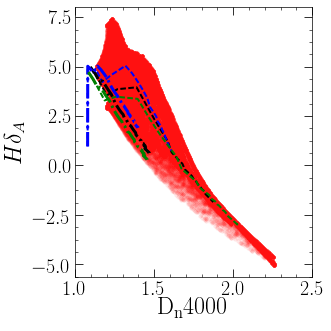

In [72]:
plt.figure(figsize=(5,5))
plt.plot(lum[:,1:,:,:,7].flatten(), lum[:,1:,:,:,5].flatten(), 'o', c='r', alpha=0.05, zorder=-1, rasterized=True)
plt.plot(indx[:,-2].reshape(-1,3)[1:,1], indx[:,4].reshape(-1,3)[1:,1], c='k', linestyle='dashed', linewidth=2)
plt.plot(indx[:,-2].reshape(-1,3)[1:,0], indx[:,4].reshape(-1,3)[1:,0], c='b', linestyle='dashed', linewidth=2)
plt.plot(indx[:,-2].reshape(-1,3)[1:,2], indx[:,4].reshape(-1,3)[1:,2], c='g', linestyle='dashed', linewidth=2)
plt.plot(indxc[:,-2].reshape(-1,3)[1:,1], indxc[:,4].reshape(-1,3)[1:,1], c='k', linestyle='-.', linewidth=3)
plt.plot(indxc[:,-2].reshape(-1,3)[1:,0], indxc[:,4].reshape(-1,3)[1:,0], c='b', linestyle='-.', linewidth=3)
plt.plot(indxc[:,-2].reshape(-1,3)[1:,2], indxc[:,4].reshape(-1,3)[1:,2], c='g', linestyle='-.', linewidth=3)
plt.xlabel(r'$\rm{D}_{\rm{n}}4000$')
plt.ylabel(r'$H\delta_A$')
plt.xlim(1, 2.5)
#plt.ylim(-6, 7)
plt.minorticks_on()
plt.tick_params(which="both", top="on", right="on", direction="in")

# Test precision in tq, tau space

In [4]:
results = np.load('/Users/becky/Projects/mangaagn/code/test_precision_mosaic/test_manga_starpy_results_log_finer_newtqs_ppxfcorrect_recent_rapid.npy')

In [6]:
deltatq = results[:,15]
deltatau = results[:,16]
origtau = (deltatau + results[:,11]).reshape(5,5).T
origtq = (deltatq + results[:,8]).reshape(5,5).T
deltatq = deltatq.reshape(5,5).T
deltatau = 10**origtau - 10**results[:,11].reshape(5,5)
errortq = np.mean([results[:,10],results[:,9]], axis=0).reshape(5,5).T
errortau = np.mean([10**results[:,11] - 10**(-results[:,13]+results[:,11]), 10**(results[:,12]+results[:,11]) - 10**results[:,11]], axis=0).reshape(5,5).T


In [7]:
10**origtau, 10**results[:,11]

(array([[0.001, 0.001, 0.001, 0.001, 0.001],
        [0.01 , 0.01 , 0.01 , 0.01 , 0.01 ],
        [0.05 , 0.05 , 0.05 , 0.05 , 0.05 ],
        [0.1  , 0.1  , 0.1  , 0.1  , 0.1  ],
        [0.2  , 0.2  , 0.2  , 0.2  , 0.2  ]]),
 array([0.00234946, 0.00175254, 0.00040511, 0.10138073, 0.2993534 ,
        0.05961625, 0.00154363, 0.00364459, 0.10142745, 0.00127467,
        0.00238436, 0.00228516, 0.0013401 , 0.00099665, 0.00150189,
        0.01672771, 0.00146106, 0.05025389, 0.10159488, 0.24239178,
        0.00016887, 0.00084763, 0.00123755, 0.02938005, 0.00163223]))

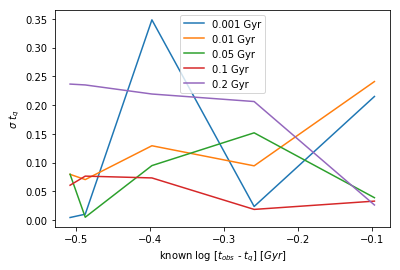

In [8]:
plt.figure()
for n in range(len(origtau)):
    plt.plot(np.log10(13.6 - origtq[n,:]), errortq[n,:], label=str(np.round(10**origtau[n,0], decimals=3))+' Gyr')
plt.legend()
plt.xlabel(r'known log [$t_{obs}$ - $t_{q}$] $[Gyr]$')
plt.ylabel(r'$\sigma$ $t_q$')

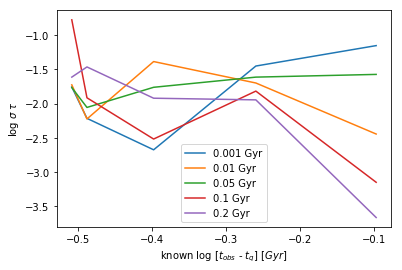

In [9]:
plt.figure()
for n in range(len(origtau)):
    plt.plot(np.log10(13.6 - origtq[n,:]), np.log10(errortau[:,n]), label=str(np.round(10**origtau[n,0], decimals=3))+' Gyr')
plt.legend()

plt.xlabel(r'known log [$t_{obs}$ - $t_{q}$] $[Gyr]$')
plt.ylabel(r'log $\sigma$ $\tau$')

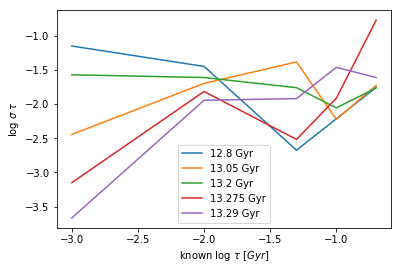

In [10]:
plt.figure()
for n in range(len(origtau)):
    plt.plot((origtau[:,n]), np.log10(errortau[:,n]), label=str(np.round(origtq[0,n], decimals=3))+' Gyr')
plt.legend()
plt.xlabel(r'known log $\tau$ $[Gyr]$')
plt.ylabel(r'log $\sigma$ $\tau$')

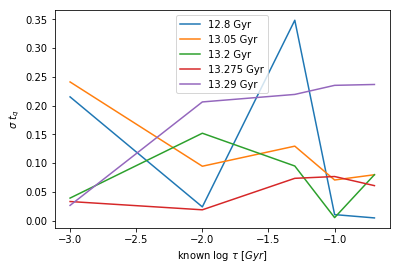

In [11]:
plt.figure()
for n in range(len(origtau)):
    plt.plot((origtau[:,n]), np.abs(errortq[n,:]), label=str(np.round(origtq[0,n], decimals=3))+' Gyr')
plt.legend()
plt.xlabel(r'known log $\tau$ $[Gyr]$')
plt.ylabel(r'$\sigma$ $t_q$')

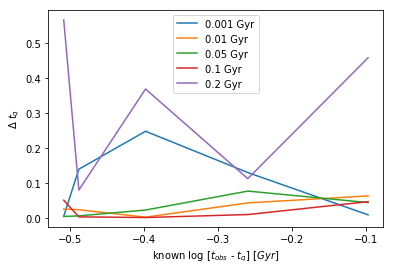

In [12]:
plt.figure()
for n in range(len(origtau)):
    plt.plot(np.log10(13.6-origtq[n,:]), np.abs(deltatq[n,:]), label=str(np.round(10**origtau[n,0], decimals=3))+' Gyr')
#plt.axvline(0, color='k', linestyle='dashed')
plt.legend()
#plt.xlim(-0.1, -2.4)
plt.xlabel(r'known log [$t_{obs}$ - $t_{q}$] $[Gyr]$')
plt.ylabel(r'$\Delta$ $t_q$')

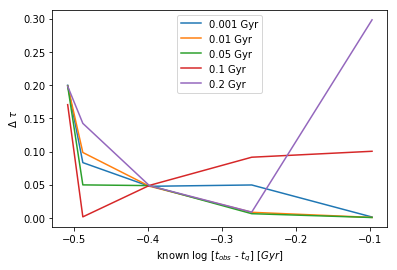

In [13]:
plt.figure()
for n in range(len(origtau)):
    plt.plot(np.log10(13.6-origtq[n,:]), np.abs(deltatau[:,n]), label=str(np.round(10**origtau[n,0], decimals=3))+' Gyr')
plt.legend()
#plt.xlim(-0.1, -2.4)
#plt.ylim(-0.1, 0.5)
plt.xlabel(r'known log [$t_{obs}$ - $t_{q}$] $[Gyr]$')
plt.ylabel(r'$\Delta$ $\tau$')

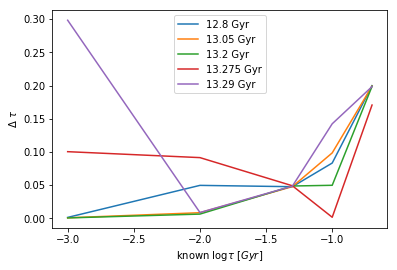

In [14]:
plt.figure()
for n in range(len(origtau)):
    plt.plot(origtau[:,n], np.abs(deltatau[:,n]), label=str(np.round(origtq[0,n], decimals=3))+' Gyr')
plt.legend()
plt.xlabel(r'known $\log \tau$ $[Gyr]$')
plt.ylabel(r'$\Delta$ $\tau$')

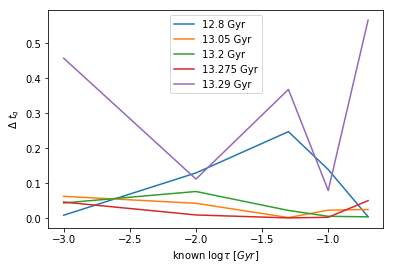

In [15]:
plt.figure()
for n in range(len(origtau)):
    plt.plot(origtau[:,n], np.abs(deltatq[n,:]), label=str(np.round(origtq[0,n], decimals=3))+' Gyr')
plt.legend()
#plt.ylim(-0.5, 0.5)
plt.xlabel(r'known $\log \tau$ $[Gyr]$')
plt.ylabel(r'$\Delta$ $t_q$')

In [26]:
np.mean(deltatau), np.mean(deltatq)

(0.02662779173610651, 0.023543530119171336)

In [27]:
np.mean(errortau), np.mean(errortq)

(0.031204340827030767, 0.1270400247503379)

In [5]:
def med(res):
    act_tau = 10**(res[:,16]+res[:,11])
    inf_tau = 10**res[:,11]
    return np.median(np.abs(res[:,14])), np.median(np.abs(res[:,15])), np.median(np.abs(act_tau-inf_tau)) 

In [6]:
def av_sigma(res):
    inf_tau = 10**res[:,11]
    plus_tau = 10**(res[:,11] + res[:,12])
    minus_tau = 10**(res[:,11]-res[:,13])
    pe_tau = plus_tau - inf_tau
    me_tau = inf_tau - minus_tau
    return np.median(res[:,6:8]), np.median(res[:,9:11]), np.median([pe_tau, me_tau])

In [9]:
results = np.load('test_precision_mosaic/test_manga_starpy_results_log_finer_newtqs_ppxfcorrect_AA.npy')

In [10]:
print(med(results))
print(av_sigma(results))

(0.062256798224422205, 0.34230150949144456, 0.9475283541489801)
(0.1236436218418924, 1.2152350719935292, 0.20458530707547246)


# Test whether consistent with other models/data

Do the models generated by FSPS and measured using MaNGA DAP agree with previous works?
The plot below shows hwo they compare to models by Kauffmann et al. (2003): https://academic.oup.com/mnras/article/341/1/33/999309 in their Figure 4: 

![figure4](https://oup.silverchair-cdn.com/oup/backfile/Content_public/Journal/mnras/341/1/10.1046_j.1365-8711.2003.06291.x/1/m_341-1-33-fig004.jpeg?Expires=2147483647&Signature=FnCldYL~-NvgwC~AbtLeEICRhnH8B5kawV7YQu1A7z0dcdPIAKtFq-Kh79b3-Y-gQn57jrc01Pwusx9L3G7OpWamqzTdQALeLcm4GP-1LzTbtzEoBVu4SPOm0U6829RcwHAAa7KfJ0ue3nwQ7SkWtuoHPEZofcy5MWXT8DzEVNXG8V4PQu7kyI3RLFja2WQ0USVQBx7qzbsuHXiAfet2unLPOJ5k8HioREVWEWbhgcLcGO5eyOf0kcrs9cGNlZStQS6w8u9CzG9DhH8p-~rnDCK27UpQWCKd22ltB~faQJyKJJpPi7Isqk2Zc6krSara8erUvyUNSr-54vxW7yehrQ__&Key-Pair-Id=APKAIE5G5CRDK6RD3PGA)

Note that their models are for burst and constant SFHs though not for quenching histories. And also that I only grabbed a couple of points off their plot using the [WebPlotDigitizer](https://apps.automeris.io/wpd/).

In [112]:
os.environ['PATH'] = os.environ['PATH'] + ':/usr/texbin'

plt.rc('figure', facecolor='none', edgecolor='none', autolayout=True)
plt.rc('path', simplify=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize='large', facecolor='none', linewidth=0.7, color_cycle = ['k', 'r', 'g', 'b', 'c', 'm', 'y'])
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('lines', markersize=4, linewidth=1, markeredgewidth=0.2)
plt.rc('legend', numpoints=1, frameon=False, handletextpad=0.3, scatterpoints=1, handlelength=2, handleheight=0.1)
plt.rc('savefig', facecolor='none', edgecolor='none', frameon='False')

params =   {'font.size' : 16,
            'xtick.major.size': 8,
            'ytick.major.size': 8,
            'xtick.minor.size': 3,
            'ytick.minor.size': 3,
            }
plt.rcParams.update(params) 

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [113]:
mgfe = np.sqrt( lum[:,:,:,:,2] * ( 0.72*lum[:,:,:,:,3] + 0.28*lum[:,:,:,:,4] )  )  

In [114]:
from astropy.table import Table
k03 = Table.read('../data/kauffmann_03_figure4_webplotdigitizer.csv', format='ascii.fast_no_header')

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


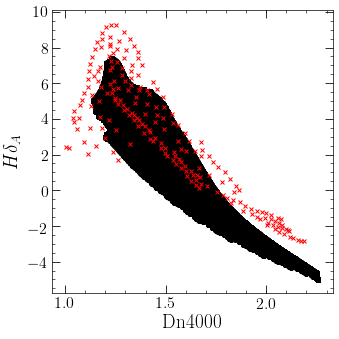

In [115]:
plt.figure(figsize=(5,5))
plt.scatter(lum[:,1:,:,:,7], lum[:,1:,:,:,5], c='k')
plt.scatter(k03['col1'], k03['col2'], marker='x', c='r')
plt.xlabel(r'Dn4000')
plt.ylabel(r'$H\delta_A$')
plt.minorticks_on()
plt.tick_params(which="both", top="on", right="on", direction="in")

We can also just plot those models of mine that have a very high tau to see whether they compare to the consant SFH track of Kauffmann et al. (2003) - the burst models create the peak, whereas the constant SFH is the main track running down. We can see these agree quite well.

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


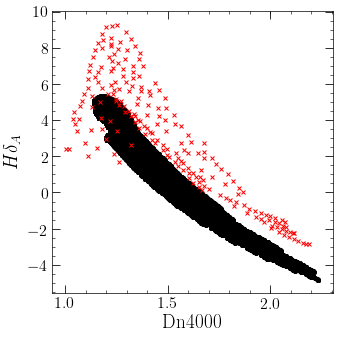

In [116]:
plt.figure(figsize=(5,5))

plt.scatter(lum[:,1:,40:,:,7], lum[:,1:,40:,:,5], c='k')
plt.scatter(k03['col1'], k03['col2'], marker='x', c='r')
plt.xlabel(r'Dn4000')
plt.ylabel(r'$H\delta_A$')
plt.minorticks_on()
plt.tick_params(which="both", top="on", right="on", direction="in")

What about Hbeta  and HdeltaA against MgFe'? I've checked with Amelia and these plots check out in terms of range in comparison to her SSP grids: 

<img src="amelia_mgfe_hdeltaA.JPG" width=500 align="left">

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


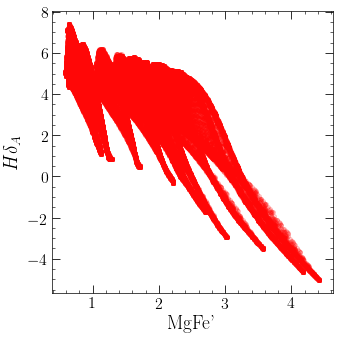

In [120]:
plt.figure(figsize=(5,5))
plt.scatter(mgfe[:,1:,:,:], lum[:,1:,:,:,5], c='r', marker='o', alpha=0.1)
plt.xlabel(r"MgFe'")
plt.ylabel(r'$H\delta_A$')
plt.tick_params(which="both", top="on", right="on", direction="in")
plt.minorticks_on()

<img src="amelia_mgfe_hbeta.JPG" width=500 align="left">


/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


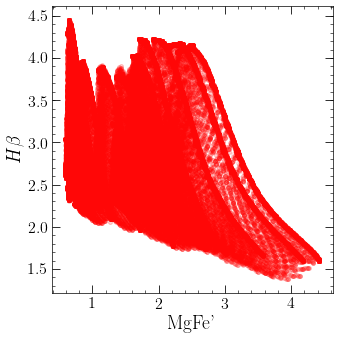

In [121]:
plt.figure(figsize=(5,5))
plt.scatter(mgfe[:,1:,:,:], lum[:,1:,:,:,1], c='r', marker='o', alpha=0.1)
plt.xlabel(r"MgFe'")
plt.ylabel(r'$H\beta$')
plt.minorticks_on()
plt.tick_params(which="both", top="on", right="on", direction="in")

Alfonso was concerned about Hbeta and HdeltaA not tracing each other either - they should correlate ish with some slope, which as you can see below they do:

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


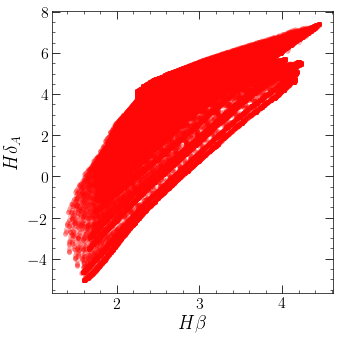

In [122]:
plt.figure(figsize=(5,5))

plt.scatter(lum[:,1:,:,:,1], lum[:,1:,:,:,5], c='r', marker='o', alpha=0.1)
plt.xlabel(r'$H\beta$')
plt.ylabel(r'$H\delta_A$')
plt.minorticks_on()
plt.tick_params(which="both", top="on", right="on", direction="in")

In [123]:
w18 = Table.read("../data/wang18_fig4_D4000_EWHa.fits", format="fits")

In [124]:
x = np.linspace(w18['XRANGE'][0][0],w18['XRANGE'][0][1], w18['MAP'][0].shape[0])
y = np.linspace(w18['YRANGE'][0][0],w18['YRANGE'][0][1], w18['MAP'][0].shape[1])
X, Y = np.meshgrid(x, y)

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


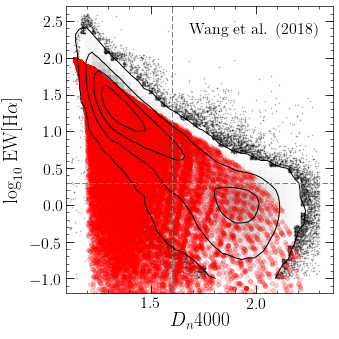

In [187]:
plt.figure(figsize=(5,5))
plt.pcolor(X, Y, w18['MAP'][0], cmap=plt.cm.binary)
plt.scatter(w18['D4000'].data, w18['EWHA'].data, color='k', marker='x', s=1, alpha=0.3, label='Wang et al. (2018)')
plt.contour(w18['MAP'][0], levels=[100,1000, 4000, 10000], extent=(w18['XRANGE'][0][0],w18['XRANGE'][0][1],w18['YRANGE'][0][0],w18['YRANGE'][0][1]), colors='k')
plt.scatter(lum[:,1:-2,:,:,7], np.log10(lum[:,1:-2,:,:,0]), c='r', alpha=0.1)
#plt.contour(Xd[:-1], Yd[:-1], Hd.T, colors='r', levels=(2, 50, 100, 1000, 5000))
plt.axvline(1.6, color='0.5', linestyle='dashed')
plt.axhline(np.log10(2), color='0.5', linestyle='dashed')
plt.xlabel(r'$D_n4000$')
plt.ylabel(r'$\log_{10}$ EW[H$\alpha]$')
plt.ylim(-1.2, 2.7)
plt.legend(frameon=False)
plt.minorticks_on()
plt.tick_params(which="both", top="on", right="on", direction="in")

In [305]:
plt.errorbar?

# I cocked up again

August 22nd 2018: Whilst trying to do the BC03 generated spectra test I came across a weird unit error - I *think* that the DAP expects the flux in flux units per AA rather than flux units per Hz as returned by FSPS. SO i've rerun the look up table to generate for per AA fluxes. I need to compare the differences between the two...

In [4]:
padova_zmet = np.array([0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0008, 0.001, 0.0012, 0.0016, 0.0020, 0.0025, 0.0031, 0.0039, 0.0049, 0.0061, 0.0077, 0.0096, 0.012, 0.015, 0.019, 0.024, 0.03])
padova_zmetsol = 0.019
padova_solmet = padova_zmet/padova_zmetsol

zmets = (np.linspace(0, 10, 11)*2 + 1).astype(int)
zsolmets = padova_solmet[(zmets-1).astype(int)] 

time_steps = Planck15.age(10**np.linspace(-0.824, -3.295, 15)).value
taus = 10**np.linspace(6, 9.778, 50)/1e9

# Load the previous generated look up table spectral parameter values 
with np.load('../snitch/snitch/spectral_parameter_measurements.npz') as orig_pred:
    pred = orig_pred['lookup'][:110000]
    
with np.load('../snitch/snitch/spectral_parameter_measurements_mask.npz') as orig_pred:
    mask = orig_pred['lookupmask'][:110000]

tqs = np.append(np.flip(time_steps.flatten()[0]- 10**(np.linspace(7, np.log10((time_steps.flatten()[0]-0.1)*1e9), 48))/1e9, axis=0), [time_steps.flatten()[0]-0.001, time_steps.flatten()[0]+0.1], axis=0)

# Create the list of combination of t_obs, tq, tau and Z values taking into account the fact that the tq grid changes everytime t_obs changes
sv = np.array(list(product([time_steps[0]], tqs, np.log10(taus), zsolmets)))
for n in range(1, 4):
    tqs = np.append(np.flip(time_steps[n]- 10**(np.linspace(7, np.log10((time_steps[n]-0.1)*1e9), 48))/1e9, axis=0), [time_steps[n]-0.001, time_steps[n]+0.1], axis=0)
    sv = np.append(sv, np.array(list(product([time_steps[n]], tqs, np.log10(taus), zsolmets))), axis=0)
    

masked_sp_hz = np.ma.masked_array(data=pred, mask=mask).reshape(4, 50, 50, 11, -1)

In [9]:
padova_zmet = np.array([0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0008, 0.001, 0.0012, 0.0016, 0.0020, 0.0025, 0.0031, 0.0039, 0.0049, 0.0061, 0.0077, 0.0096, 0.012, 0.015, 0.019, 0.024, 0.03])
padova_zmetsol = 0.019
padova_solmet = padova_zmet/padova_zmetsol

zmets = (np.linspace(0, 10, 11)*2 + 1).astype(int)
zsolmets = padova_solmet[(zmets-1).astype(int)] 

time_steps = Planck15.age(10**np.linspace(-0.824, -3.295, 15)).value
taus = 10**np.linspace(6, 9.778, 50)/1e9

# Load the previous generated look up table spectral parameter values 
with np.load('../data/emls_par_pool_mapped_nozshift_ppxfcorrect_AA.npz') as orig_pred:
    pred = orig_pred['lookup'][:110000]
    
with np.load('../data/emls_mask_par_pool_mapped_nozshift_ppxfcorrect_AA.npz') as orig_pred:
    mask = orig_pred['lookupmask'][:110000]

tqs = np.append(np.flip(time_steps.flatten()[0]- 10**(np.linspace(7, np.log10((time_steps.flatten()[0]-0.1)*1e9), 48))/1e9, axis=0), [time_steps.flatten()[0]-0.001, time_steps.flatten()[0]+0.1], axis=0)

# Create the list of combination of t_obs, tq, tau and Z values taking into account the fact that the tq grid changes everytime t_obs changes
sv = np.array(list(product([time_steps[0]], tqs, np.log10(taus), zsolmets)))
for n in range(1, 4):
    tqs = np.append(np.flip(time_steps[n]- 10**(np.linspace(7, np.log10((time_steps[n]-0.1)*1e9), 48))/1e9, axis=0), [time_steps[n]-0.001, time_steps[n]+0.1], axis=0)
    sv = np.append(sv, np.array(list(product([time_steps[n]], tqs, np.log10(taus), zsolmets))), axis=0)
    

masked_sp_aa = np.ma.masked_array(data=pred, mask=mask).reshape(4, 50, 50, 11, -1)


(4, 50, 50, 11, 9)

In [10]:
mgfe_hz = np.sqrt( masked_sp_hz[:,:,:,:,2] * ( 0.72*masked_sp_hz[:,:,:,:,3] + 0.28*masked_sp_hz[:,:,:,:,4] )  )  

In [11]:
mgfe_aa = np.sqrt( masked_sp_aa[:,:,:,:,2] * ( 0.72*masked_sp_aa[:,:,:,:,3] + 0.28*masked_sp_aa[:,:,:,:,4] )  )  

In [35]:
lum = (masked_sp_aa - masked_sp_hz)/masked_sp_hz

In [36]:
zmets[9]

19

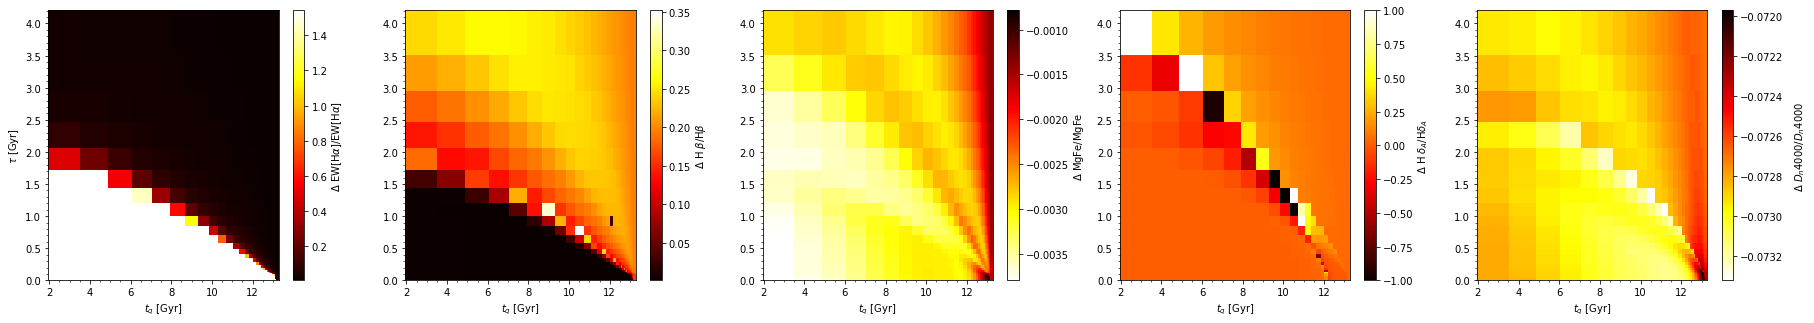

In [50]:
f = 3
g = 9

tqs = np.append(np.flip(time_steps.flatten()[f]- 10**(np.linspace(7, np.log10((time_steps.flatten()[f]-0.1)*1e9), 48))/1e9, axis=0), [time_steps.flatten()[f]-0.001, time_steps.flatten()[f]+0.1], axis=0)

fig =plt.figure(figsize=(25.3,4.6))
ax = plt.subplot2grid((1,5), (0, 0))
cb = ax.pcolor(tqs[1:], taus[:-2], lum[f,1:,:-2, g, 0].T,  cmap=plt.cm.hot)
# ax.set_xlim(np.max(time_steps[f]-tqs[1:]), np.min(time_steps[f]-tqs[1:]))
ax.set_xlim(np.min(tqs[1:]), np.max(tqs[1:]))
ax.set_ylim(np.min(taus[:-2]),np.max(taus[:-2]))

the_divider = make_axes_locatable(ax)
cax = the_divider.append_axes("right", size="5%", pad=0.2)

cbar = plt.colorbar(cb, cax=cax)
cbar.set_label(r'$\Delta$ EW[H$\alpha$]/EW[H$\alpha$]', labelpad=3)
ax.set_xlabel(r'$t_q$ $\rm{[Gyr]}$')
ax.set_ylabel(r'$\tau$ $\rm{[Gyr]}$')
ax.minorticks_on()

# ax = plt.subplot2grid((2,3), (0, 1))
# cb = ax.pcolor(tqs[1:], taus, lum[f,1:,:, g,1].T, cmap=plt.cm.hot)
# ax.set_xlim(np.min(tqs[1:]), np.max(tqs[1:]))
# ax.set_ylim(np.min(taus), np.max(taus))

# the_divider = make_axes_locatable(ax)
# cax = the_divider.append_axes("right", size="5%", pad=0.2)

# cbar = plt.colorbar(cb, cax=cax)
# cbar.set_label(r'EW [OII]', labelpad=2)
# ax.set_ylabel(r'$\tau$ $\rm{[Gyr]}$')
# ax.minorticks_on()

ax = plt.subplot2grid((1,5), (0, 1))
cb = ax.pcolor(tqs[1:], taus[:-2], lum[f,1:,:-2, g,1].T, cmap=plt.cm.hot)
ax.set_xlim(np.min(tqs[1:]), np.max(tqs[1:]))
ax.set_ylim(np.min(taus[:-2]), np.max(taus[:-2]))

the_divider = make_axes_locatable(ax)
cax = the_divider.append_axes("right", size="5%", pad=0.2)

cbar = plt.colorbar(cb, cax=cax)
cbar.set_label(r'$\Delta$ H $\beta$/H$\beta$', labelpad=3)
ax.set_xlabel(r'$t_q$ $\rm{[Gyr]}$')
ax.minorticks_on()

ax = plt.subplot2grid((1,5), (0,2))
#mgfe = np.sqrt( lum[f,1:,:-2, g,2].T * ( 0.72*lum[f,1:,:-2, g,3].T + 0.28*lum[f,1:,:-2, g,4].T )  )
mgfe = mgfe_aa[f,1:,:-2, g] - mgfe_hz[f,1:,:-2, g]
cb = ax.pcolor(tqs[1:], taus[:-2], mgfe.T,  cmap=plt.cm.hot_r)
ax.set_xlim(np.min(tqs[1:]), np.max(tqs[1:]))
ax.set_ylim(np.min(taus[:-2]), np.max(taus[:-2]))

the_divider = make_axes_locatable(ax)
cax = the_divider.append_axes("right", size="5%", pad=0.2)

cbar = plt.colorbar(cb, cax=cax)
cbar.set_label(r'$\Delta$ MgFe/MgFe', labelpad=3)
ax.set_xlabel(r'$t_q$ $\rm{[Gyr]}$')
ax.minorticks_on()

ax = plt.subplot2grid((1,5), (0,3))
cb = ax.pcolor(tqs[1:], taus[:-2], lum[f,1:,:-2, g,5].T, cmap=plt.cm.hot, vmin=-1, vmax=1)
ax.set_xlim(np.min(tqs[1:]), np.max(tqs[1:]))
ax.set_ylim(np.min(taus[:-2]), np.max(taus[:-2]))

the_divider = make_axes_locatable(ax)
cax = the_divider.append_axes("right", size="5%", pad=0.2)

cbar = plt.colorbar(cb, cax=cax)
cbar.set_label(r'$\Delta$ H $\delta_A$/H$\delta_A$', labelpad=3)
ax.set_xlabel(r'$t_q$ $\rm{[Gyr]}$')
ax.minorticks_on()

ax = plt.subplot2grid((1,5), (0,4))
cb = ax.pcolor(tqs[1:], taus[:-2], lum[f,1:,:-2, g,7].T, cmap=plt.cm.hot_r)
#ax.set_xlim(np.min(time_steps[f]-tqs[1:]), np.max(time_steps[f]-tqs[1:]))
ax.set_xlim(np.min(tqs[1:]), np.max(tqs[1:]))
ax.set_ylim(np.min(taus[:-2]), np.max(taus[:-2]))

the_divider = make_axes_locatable(ax)
cax = the_divider.append_axes("right", size="5%", pad=0.2)

cbar = plt.colorbar(cb, cax=cax)
cbar.set_label(r'$\Delta$ $D_n$4000/$D_n$4000', labelpad=10)
ax.set_xlabel(r'$t_q$ $\rm{[Gyr]}$')
ax.minorticks_on()

#plt.title(r'$t_{\rm{obs}}$: %.5g $\rm{Gyr}$' % time_steps[f] +  r', $Z$: %.5g' % zsolmets[g])
plt.tight_layout()
#plt.subplots_adjust(hspace=0.1)
plt.savefig('fsps_rainbow_spectral_features_difference_hz_aa.pdf', frameon=False, bbox_inches='tight', pad_inches=0.0, transparent=True)

In [15]:
from astropy.table import Table

In [16]:
w18 = Table.read("../data/wang18_fig4_D4000_EWHa.fits", format="fits")

In [17]:
x = np.linspace(w18['XRANGE'][0][0],w18['XRANGE'][0][1], w18['MAP'][0].shape[0])
y = np.linspace(w18['YRANGE'][0][0],w18['YRANGE'][0][1], w18['MAP'][0].shape[1])
X, Y = np.meshgrid(x, y)

/usr/local/Cellar/python3/3.6.0/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


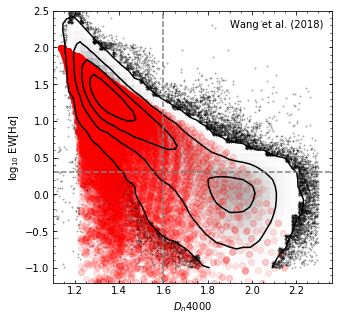

In [27]:
plt.figure(figsize=(5,5))
plt.pcolor(X, Y, w18['MAP'][0], cmap=plt.cm.binary)
plt.scatter(w18['D4000'].data, w18['EWHA'].data, color='k', marker='x', s=1, alpha=0.3, label='Wang et al. (2018)')
plt.contour(w18['MAP'][0], levels=[100,1000, 4000, 10000], extent=(w18['XRANGE'][0][0],w18['XRANGE'][0][1],w18['YRANGE'][0][0],w18['YRANGE'][0][1]), colors='k')
plt.scatter(masked_sp_aa[:,1:,:,:,7], np.log10(masked_sp_aa[:,1:,:,:,0]), c='r', alpha=0.1)
#plt.contour(Xd[:-1], Yd[:-1], Hd.T, colors='r', levels=(2, 50, 100, 1000, 5000))
plt.axvline(1.6, color='0.5', linestyle='dashed')
plt.axhline(np.log10(2), color='0.5', linestyle='dashed')
plt.xlabel(r'$D_n4000$')
plt.ylabel(r'$\log_{10}$ EW[H$\alpha]$')
plt.ylim(-1.2, 2.5)
plt.legend(frameon=False)
plt.minorticks_on()
plt.tick_params(which="both", top="on", right="on", direction="in")

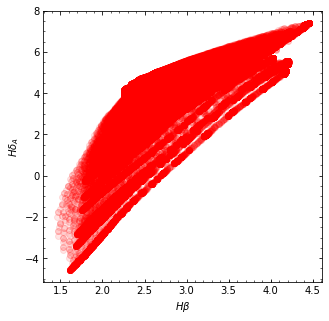

In [43]:
plt.figure(figsize=(5,5))

plt.scatter(masked_sp_aa[:,1:,:,:,1], masked_sp_aa[:,1:,:,:,5], c='r', marker='o', alpha=0.1)
plt.xlabel(r'$H\beta$')
plt.ylabel(r'$H\delta_A$')
plt.minorticks_on()
plt.tick_params(which="both", top="on", right="on", direction="in")

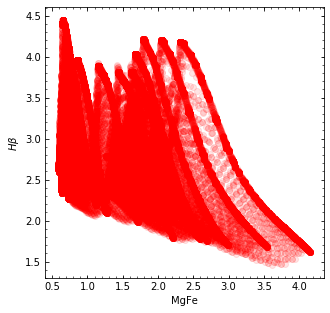

In [44]:
plt.figure(figsize=(5,5))
plt.scatter(mgfe_aa[:,1:,:,:], masked_sp_aa[:,1:,:,:,1], c='r', marker='o', alpha=0.1)
plt.xlabel(r'MgFe')
plt.ylabel(r'$H\beta$')
plt.minorticks_on()
plt.tick_params(which="both", top="on", right="on", direction="in")

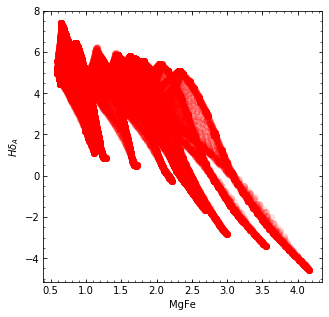

In [45]:
plt.figure(figsize=(5,5))
plt.scatter(mgfe_aa[:,1:,:,:], masked_sp_aa[:,1:,:,:,5], c='r', marker='o', alpha=0.1)
plt.xlabel(r'MgFe')
plt.ylabel(r'$H\delta_A$')
plt.tick_params(which="both", top="on", right="on", direction="in")
plt.minorticks_on()

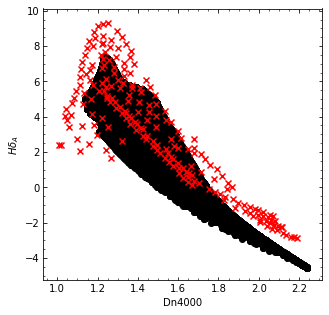

In [47]:
plt.figure(figsize=(5,5))
plt.scatter(masked_sp_aa[:,1:,:,:,7], masked_sp_aa[:,1:,:,:,5], c='k')
plt.scatter(k03['col1'], k03['col2'], marker='x', c='r')
plt.xlabel(r'Dn4000')
plt.ylabel(r'$H\delta_A$')
plt.minorticks_on()
plt.tick_params(which="both", top="on", right="on", direction="in")

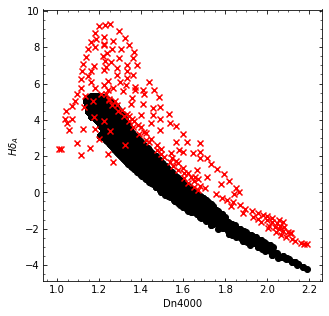

In [49]:
plt.figure(figsize=(5,5))
plt.scatter(masked_sp_aa[:,1:,40:,:,7], masked_sp_aa[:,1:,40:,:,5], c='k')
plt.scatter(k03['col1'], k03['col2'], marker='x', c='r')
plt.xlabel(r'Dn4000')
plt.ylabel(r'$H\delta_A$')
plt.minorticks_on()
plt.tick_params(which="both", top="on", right="on", direction="in")